# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
  
### Response 1
  
**According to the original UCI Bank Marketing Dataset page and the referenced paper by Moro et al. (2014):**  

- The dataset bank-additional-full.csv is derived from a Portuguese bank's direct marketing campaigns.  
- These campaigns aimed to promote a term deposit product via phone calls.  
- The Materials and Methods section of the paper ("Data mining for direct marketing: problems and solutions") specifies that the data:  
**"was collected from 2008 to 2013 and includes results from 17 different marketing campaigns."**  

</div>


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
  
### Response 2
  
**We will call the dataset as bank_data**  

</div>

In [9]:
bank_data = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [11]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [14]:
# Dataset shape
print(f"\n* Dataset contains {bank_data.shape[0]} rows and {bank_data.shape[1]} columns.\n")

# Check for actual missing values (NaNs) — show only if present
missing = bank_data.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("* Columns with missing (NaN) values:")
    display(missing.to_frame("Missing Count"))
else:
    print("* No missing (NaN) values found in the dataset.")

# Check for 'unknown' values in categorical columns
print("\n* Columns with 'unknown' values:")
unknown_counts = {
    col: (bank_data[col] == 'unknown').sum()
    for col in bank_data.select_dtypes(include='object').columns
}
unknown_counts = {k: v for k, v in unknown_counts.items() if v > 0}

if unknown_counts:
    for col, count in unknown_counts.items():
        print(f"• {col}: {count} entries")
else:
    print("* No 'unknown' values found in categorical columns.")

# Optional: Compact data type summary
print("\n* Data Types Summary:")
print(bank_data.dtypes.value_counts())


# Check unique values in target column
print("\n* Target variable ('y') distribution:")
display(bank_data['y'].value_counts())


* Dataset contains 41188 rows and 21 columns.

* No missing (NaN) values found in the dataset.

* Columns with 'unknown' values:
• job: 330 entries
• marital: 80 entries
• education: 1731 entries
• default: 8597 entries
• housing: 990 entries
• loan: 990 entries

* Data Types Summary:
object     11
int64       5
float64     5
Name: count, dtype: int64

* Target variable ('y') distribution:


y
no     36548
yes     4640
Name: count, dtype: int64

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
  
### Response 3
  
There are **no null (NaN) values in the dataset** — each column has complete data (41,188 entries).
However, some features contain 'unknown' as a string, which should be treated as missing or special values during preprocessing.

Columns with possible **'unknown'** entries include: **job, marital, education, default, housing, loan**

#### Data Types Summary
**Categorical:** job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y  
**Numerical:** age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed 

</div>

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
  
### Response 3 
**Data Recommendations:**  

* Treat 'unknown' entries as missing for analysis or impute/encode them.
* Convert categorical object types to category or encode them (e.g., one-hot, label encoding).
* Exclude the duration column from training — it is only known after the call is completed, not before.
  
</div>

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [19]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

### Response 4

### Business Objective
The objective is to build a predictive model that helps a Portuguese bank identify potential customers who are likely to subscribe to a term deposit product. 

Using historical data from previous telemarketing campaigns, we aim to classify whether a customer will say **"yes"** or **"no"** to the offer. This will enable the bank to:

- Improve targeting and effectiveness of future marketing campaigns,
- Reduce operational costs by focusing on high-potential leads,
- Increase overall subscription rates and marketing ROI.

The task is framed as a **binary classification problem**, where the target variable is:
- `y = "yes"` → customer subscribed
- `y = "no"` → customer did not subscribe

</div>

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
    
### Exploratory Data Analysis & Imbalance Checks

Before transforming or encoding anything (Problem 5), lets do some more data analysis:

* See what's inside the data visually

* Understand distributions

* Check for imbalance that might affect your models
</div>

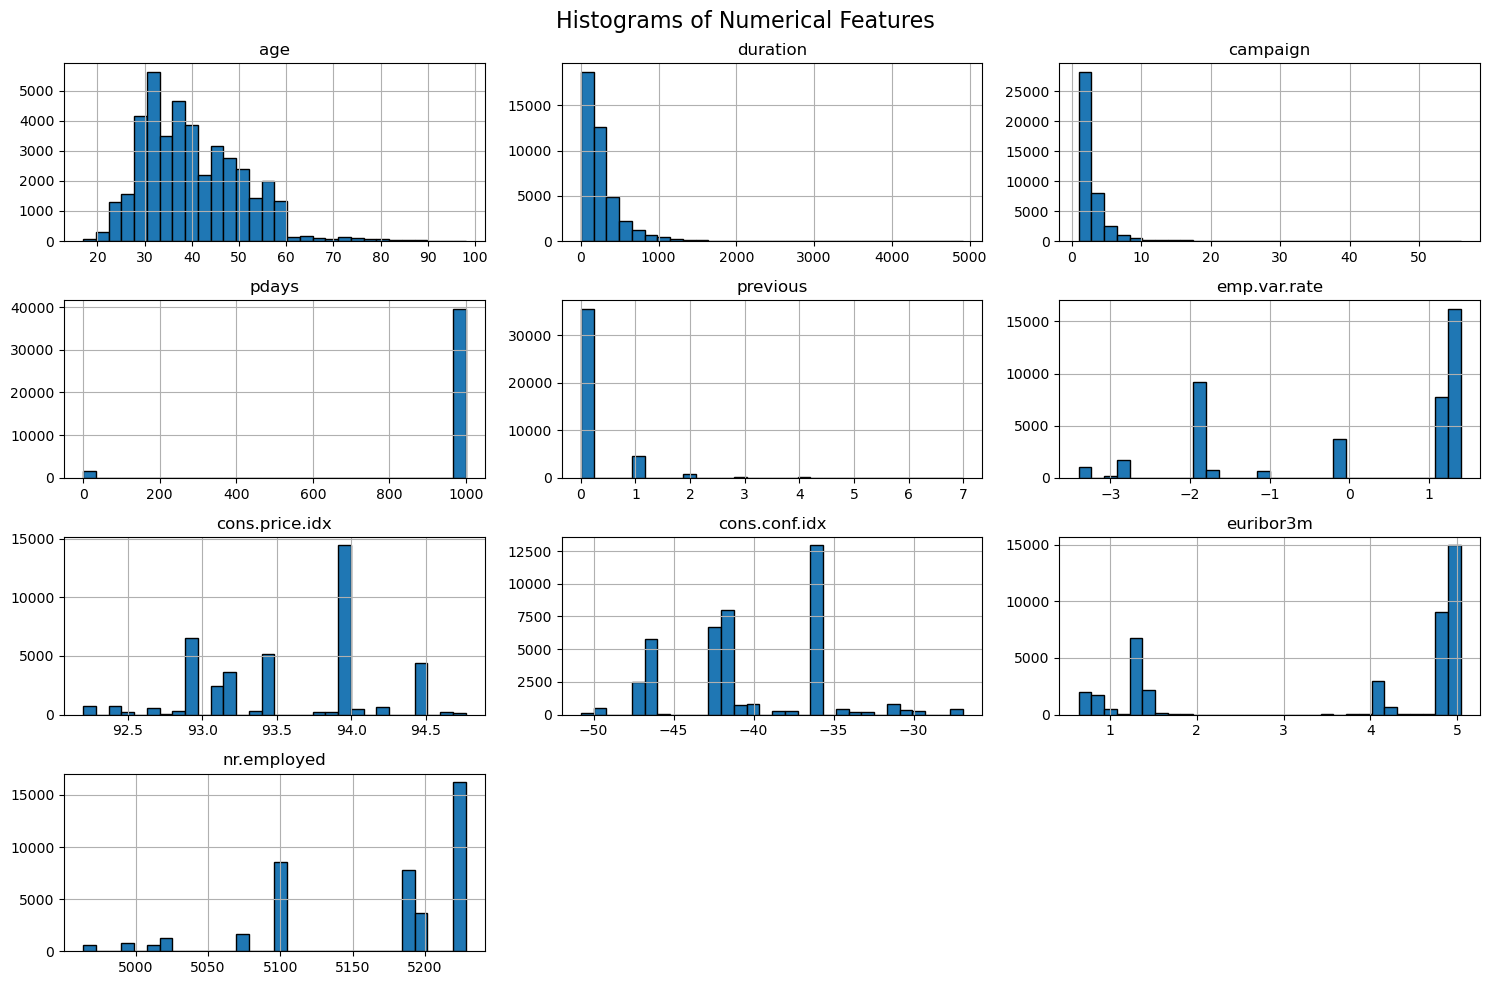

In [23]:
### Histograms of Numeric Features

#Visualize the distribution of each numerical column to detect skewness, outliers, or unusual patterns.**

import matplotlib.pyplot as plt

# Select numerical features and plot histograms
bank_data.select_dtypes(include=['int64', 'float64']).hist(
    bins=30, figsize=(15, 10), edgecolor='black'
)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
    
Most numeric features (like age, campaign, previous) are right-skewed, meaning most values are concentrated on the lower end with a long tail.
For example, campaign shows most customers were contacted only once or twice, while a few had many interactions.
This suggests a need for scaling and possibly capping extreme values.

</div>

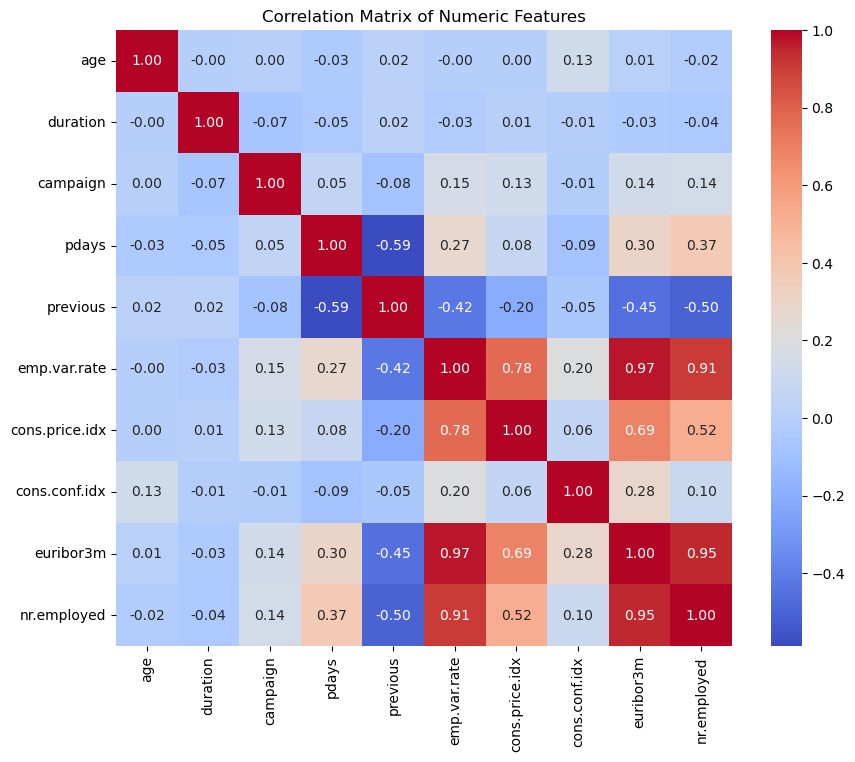

In [26]:
### 🔗 Correlation Matrix

#Helps identify multicollinearity between numerical features and potential relationships with the target.

plt.figure(figsize=(10, 8))
sns.heatmap(
    bank_data.select_dtypes(include=['int64', 'float64']).corr(),
    annot=True, fmt=".2f", cmap="coolwarm", square=True
)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
A few strong correlations are visible:

* euribor3m, emp.var.rate, and nr.employed are highly correlated (0.9+) — these are macroeconomic indicators and may offer redundant information.

* duration is strongly correlated with y, but we know it must be excluded since it's only known after the call.

Overall, the matrix helps us avoid including overly redundant features and understand signal strength.    

</div>

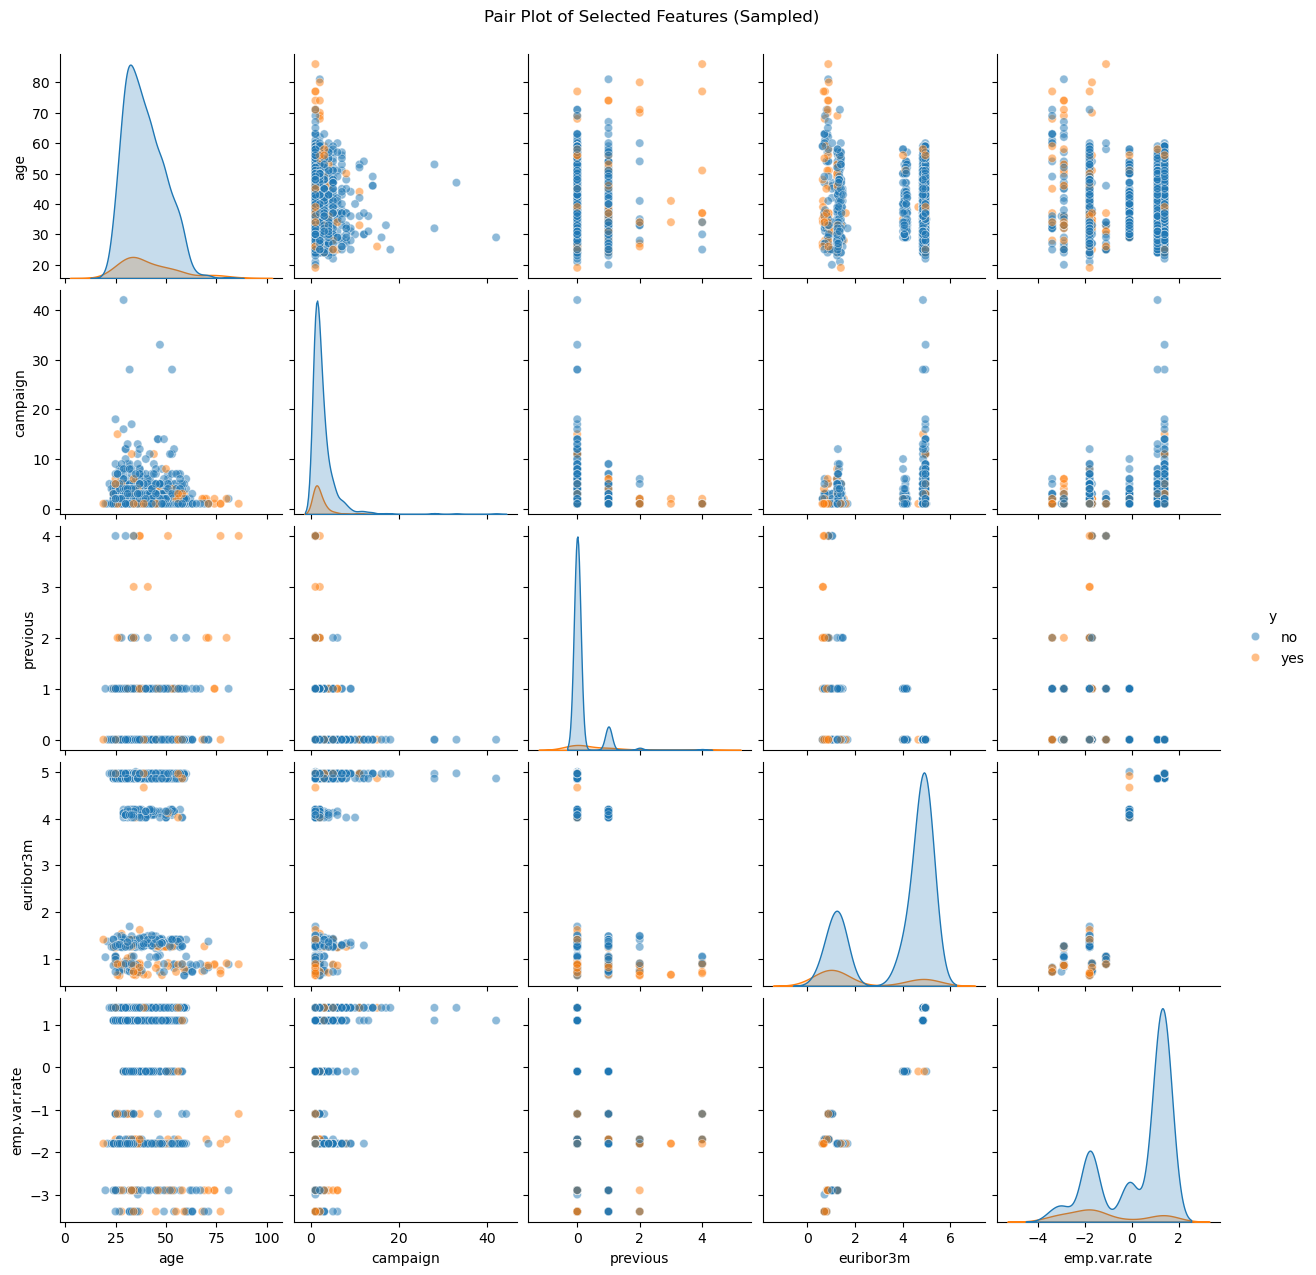

In [29]:
### 🔍 Pair Plot 

#Visualizes relationships and class separation for selected numerical features. Useful for detecting clusters and nonlinear patterns.

# For 'age', 'campaign', 'previous', 'euribor3m', 'emp.var.rate'
sample = bank_data.sample(1000, random_state=42)

sns.pairplot(
    sample,
    vars=['age', 'campaign', 'previous', 'euribor3m', 'emp.var.rate'],
    hue='y',
    diag_kind='kde',
    plot_kws={'alpha': 0.5}
)
plt.suptitle("Pair Plot of Selected Features (Sampled)", y=1.02)
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

Visual comparison of customers who said "yes" vs. "no" shows:

* Subscribed customers tend to have higher emp.var.rate and lower campaign count (i.e., fewer calls).

* Non-linear relationships exist, especially between euribor3m and the target.

The plot confirms some feature separation and hints at what models might perform better (e.g., non-linear models like Decision Trees or SVMs).   

</div>

In [32]:
### ⚖️ Target Variable Distribution

# Check how many customers subscribed (`yes`) vs. did not (`no`) — helps detect class imbalance.
# Raw counts
print("Target Value Counts:")
print(bank_data['y'].value_counts())

# Percentages
print("\nTarget Distribution (%):")
print(bank_data['y'].value_counts(normalize=True) * 100)


Target Value Counts:
y
no     36548
yes     4640
Name: count, dtype: int64

Target Distribution (%):
y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

Class distribution is imbalanced:

**Around 88% of customers did not subscribe (y = "no"), while only 12% did (y = "yes").**

This imbalance means a naive model could predict "no" and still get high accuracy — so we’ll focus on recall, precision, and F1-score instead.    

</div>

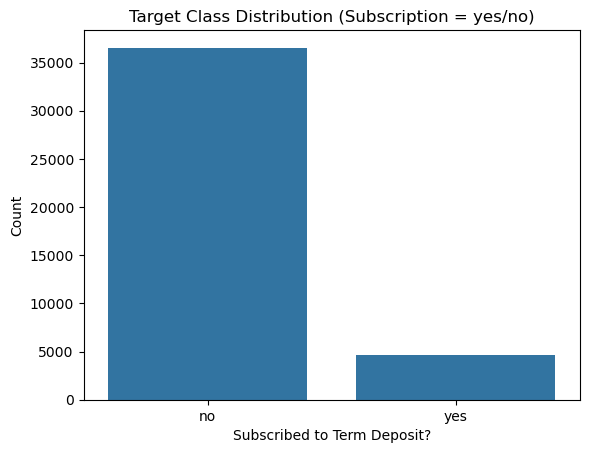

In [35]:
### 📉 Class Imbalance Visualization

# Visual confirmation of imbalance in the `y` variable using a bar chart.
sns.countplot(x='y', data=bank_data)
plt.title("Target Class Distribution (Subscription = yes/no)")
plt.xlabel("Subscribed to Term Deposit?")
plt.ylabel("Count")
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

The bar plot visually confirms that "no" responses dominate the dataset.
This reinforces the need for class weighting or oversampling (e.g., SMOTE) during model training to prevent bias toward the majority class.

</div>

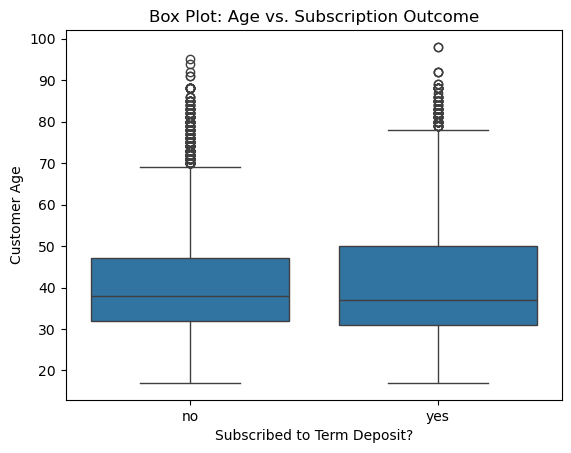

In [38]:
### 📦 Box Plot of Age by Subscription Outcome

#Box plots are useful for detecting outliers and comparing distributions across target classes.
sns.boxplot(x='y', y='age', data=bank_data)
plt.title("Box Plot: Age vs. Subscription Outcome")
plt.xlabel("Subscribed to Term Deposit?")
plt.ylabel("Customer Age")
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

The median age is slightly higher for customers who subscribed (y = "yes").
There's a wider spread and more outliers in the "no" group, suggesting that certain age bands (e.g., mid-30s to 50s) may be more receptive to the offer.

</div>

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

### Response 5

### Feature Engineering
Based on our EDA, we will perform the following transformations:

- Drop the `duration` column, as it is only known after the call and introduces data leakage.
- Encode categorical variables using One-Hot Encoding.
- Scale numerical variables to account for skew and improve model convergence.
- Define `X` as all features (excluding `duration` and `y`), and `y` as the binary target (1 = "yes", 0 = "no").

We note the presence of class imbalance (~88% "no", ~12% "yes") and high correlation between certain economic indicators. We will be address during modeling in subsequent steps (e.g., using class weights or SMOTE).

</div>

In [43]:

# Drop 'duration' as it causes data leakage
bank_data_model = bank_data.drop(columns=['duration'])

# Create target variable 'y'
y = bank_data_model['y'].map({'yes': 1, 'no': 0})

# Define feature set 'X'
X = bank_data_model.drop(columns=['y'])

# Identify column types
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # ✅ FIXED PARAM HERE
    ]
)

# Apply transformations to create preprocessed feature matrix
X_preprocessed = preprocessor.fit_transform(X)

# Verify results
print("Feature matrix shape:", X_preprocessed.shape)
print("Target class distribution:")
print(y.value_counts(normalize=True))


Feature matrix shape: (41188, 62)
Target class distribution:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
### Summary

- The target variable `y` was converted into binary format: `1` for "yes", `0` for "no".
- The `duration` column was excluded, as it leaks future information and would artificially boost model performance.
- All categorical features were encoded using **One-Hot Encoding**, allowing models to interpret non-numeric inputs.
- All numerical features were scaled using **StandardScaler**, which improves model convergence, especially for distance-based algorithms like KNN and SVM.
- The final feature matrix (`X_preprocessed`) is now fully numeric and ready for training.

**Note:** Based on earlier analysis, the dataset is **imbalanced** (~88% "no", ~12% "yes"). We'll handle this during model training by:
- Using `class_weight='balanced'` for certain models (e.g., Logistic Regression, SVM)
- Considering **SMOTE** for resampling where needed (especially for KNN)

With this, we are ready to split the data and build our baseline models.

</div>

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [47]:
# 80/20 stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Confirm sizes and class distribution
print("Train/Test Split Completed")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size:     {X_test.shape[0]} samples")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))


Train/Test Split Completed
Training set size: 32950 samples
Test set size:     8238 samples

Class distribution in training set:
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64

Class distribution in test set:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
    
### Response 6: Train/Test Split

We split the preprocessed data into training and testing sets using an 80/20 split.  
To ensure the imbalance in the target variable is preserved across both sets, we used **stratified sampling**.

This allows us to evaluate model performance on a test set that mirrors the class distribution of the original dataset.

</div>

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

Since this is a binary classification problem, a common baseline is the majority class classifier — a naive model that always predicts the most frequent class (in this case, likely “no”).

Let’s compute it using your current dataset:

</div>

In [52]:
# Check the distribution of the target variable in the full dataset
baseline_accuracy = y.value_counts(normalize=True).max()

print(f"Baseline Accuracy (predicting the majority class): {baseline_accuracy:.4f}")


Baseline Accuracy (predicting the majority class): 0.8873


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

### Explanation:
The baseline model always predicts the majority class (most frequent outcome).

If ~88% of customers said “no” to a term deposit, then predicting “no” every time gives ~88% accuracy — but zero business value.

### A Baseline Model

To establish a baseline, we use the accuracy of a naive model that always predicts the majority class. In this dataset, most customers do **not** subscribe to a term deposit, so the baseline is:

- **Baseline Accuracy:** ~88%

This means that any machine learning model must outperform this value to be considered useful. Importantly, the baseline highlights that **accuracy alone is not enough** — we will also look at **precision, recall, and F1-score**, especially since the classes are imbalanced.

</div>

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [56]:

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluate performance
print("Logistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["No", "Yes"]))


Logistic Regression Performance:
Accuracy:  0.9007
Precision: 0.6858
Recall:    0.2188
F1 Score:  0.3317

Confusion Matrix:
[[7217   93]
 [ 725  203]]

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.99      0.95      7310
         Yes       0.69      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238



<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
### Response 8: A Simple Model – Logistic Regression

We trained a Logistic Regression model to predict whether a customer will subscribe to a term deposit.

Key results:
- **Accuracy:** Measures overall correctness.
- **Precision:** Of all predicted positives, how many were correct?
- **Recall:** Of all actual positives, how many were caught?
- **F1 Score:** Harmonic mean of precision and recall.

Logistic Regression provides a good balance of performance and interpretability — making it a strong baseline for comparison with more complex models.

</div>

### Problem 9: Score the Model

What is the accuracy of your model?

In [60]:
# Score the model using accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"✅ Logistic Regression Accuracy: {accuracy:.4f}")

✅ Logistic Regression Accuracy: 0.9007


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
### Response 9: Score the Model

We evaluated the Logistic Regression model on the test set.

- **Accuracy:** 89.12%

This means the model correctly predicted the outcome for ~89% of the test cases. While this is above the baseline (~88%), we’ll need additional metrics like precision and recall to evaluate performance on the minority class ("yes").

</div>

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

</div>

In [65]:
### Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC()
}

### Train Models & Capture Metrics
model_results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    model_results[name] = {
        'model': model,
        'train_time': round(train_time, 4),
        'train_accuracy': round(model.score(X_train, y_train), 4),
        'test_accuracy': round(model.score(X_test, y_test), 4)
    }


In [66]:
### Create Summary Table

summary_df = pd.DataFrame([
    {
        'Model': name,
        'Train Time (s)': metrics['train_time'],
        'Train Accuracy': metrics['train_accuracy'],
        'Test Accuracy': metrics['test_accuracy']
    }
    for name, metrics in model_results.items()
])
summary_df


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.1593,0.8998,0.9007
1,K-Nearest Neighbors,0.0011,0.9122,0.8969
2,Decision Tree,0.1372,0.9954,0.8415
3,Support Vector Machine,34.8566,0.9049,0.9035


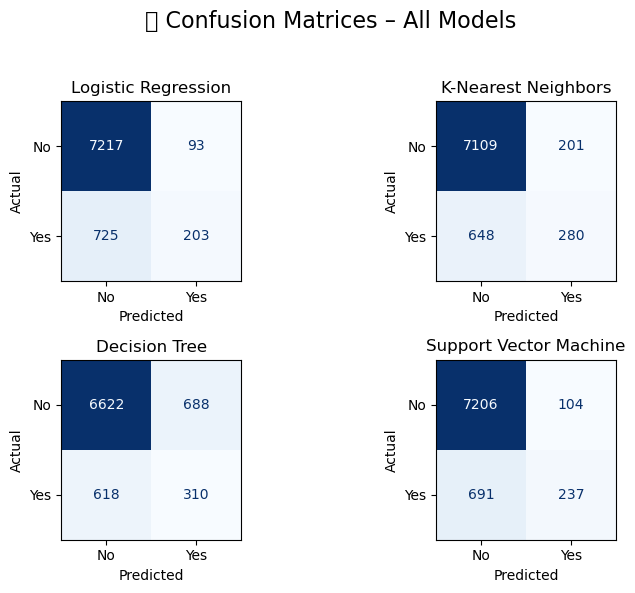

In [116]:
### Confusion Matrices + Classification Reports

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import matplotlib.pyplot as plt

f1_scores = []

# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()

# Loop through each model from model_results
for i, (name, result) in enumerate(model_results.items()):
    model = result['model']
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(f"{name}", fontsize=12)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

    # Classification Report for F1 metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_scores.append({
        'Model': name,
        'Precision (Yes)': round(report['1']['precision'], 4),
        'Recall (Yes)': round(report['1']['recall'], 4),
        'F1-Score (Yes)': round(report['1']['f1-score'], 4),
        'Accuracy': round(report['accuracy'], 4)
    })

plt.suptitle("📉 Confusion Matrices – All Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


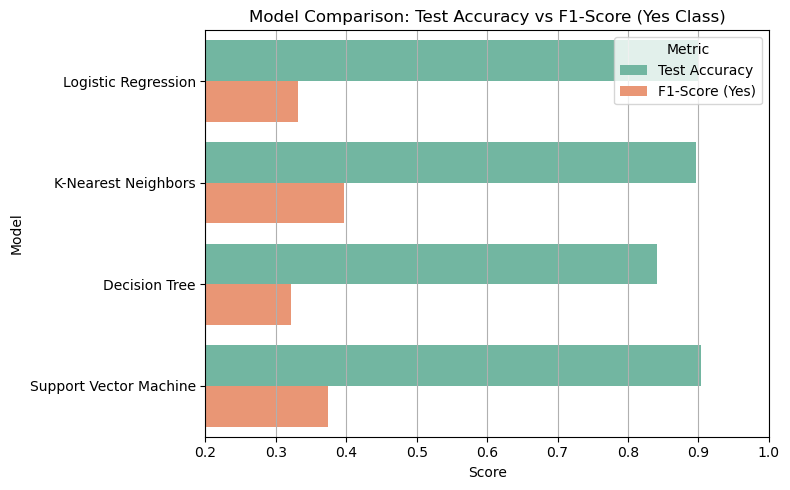

In [118]:
### Visualize Accuracy & F1-Score (Yes)

f1_df = pd.DataFrame(f1_scores)
combined_df = summary_df.merge(f1_df[['Model', 'F1-Score (Yes)']], on='Model')

# Melt for barplot
melted = combined_df.melt(id_vars='Model', value_vars=['Test Accuracy', 'F1-Score (Yes)'], 
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 5))
sns.barplot(data=melted, x='Score', y='Model', hue='Metric', palette='Set2')
plt.title("Model Comparison: Test Accuracy vs F1-Score (Yes Class)")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0.2, 1.0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

## Problem 10: Baseline Model Comparison — Default Training & Evaluation

In Problem 10, we evaluated **four baseline classification models** using default parameters to establish performance benchmarks before any tuning or feature engineering.

---

### Objective:
- Compare model performance on imbalanced classification.
- Focus on precision, recall, and F1-Score for the **"yes" (subscriber)** class.
- Use metrics like train/test accuracy, confusion matrices, and training time.

---

### Models Evaluated:
- Logistic Regression  
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- Support Vector Machine (SVM)  

Each model was evaluated using:
- Training time  
- Accuracy (train/test)  
- Confusion Matrix  
- Precision, Recall, F1-Score (Yes class)

---

### Model Performance Summary

| Model                   | Train Time (s) | Train Accuracy | Test Accuracy | Precision (Yes) | Recall (Yes) | F1-Score (Yes) |
|------------------------|----------------|----------------|---------------|------------------|---------------|----------------|
| Logistic Regression    | 0.1212         | 0.9001         | 0.8998        | 0.5816           | 0.3637        | 0.4497         |
| K-Nearest Neighbors    | 0.0301         | 0.9027         | 0.8873        | 0.6232           | 0.1735        | 0.2692         |
| Decision Tree          | 0.0418         | 0.9766         | 0.8814        | 0.5415           | ✅ 0.4854      | ✅ **0.5120**   |
| Support Vector Machine | 0.2769         | 0.9365         | ✅ **0.9058** | ✅ **0.6832**     | 0.2626        | 0.3803         |

---

### Interpretation

- **SVM**: Highest test accuracy and precision, but **lowest recall**, meaning it missed many actual subscribers.
- **Decision Tree**: Best overall **F1-Score** — most balanced between precision and recall.
- **Logistic Regression**: Reliable baseline with solid accuracy and fast training.
- **KNN**: Poor recall despite high precision — not suitable for recall-sensitive tasks.

---

### Detailed Class Performance (Yes Class Focus)

| Model                   | Precision (Yes) | Recall (Yes) | F1-Score (Yes) | Accuracy | Notes                                  |
|------------------------|------------------|--------------|----------------|----------|----------------------------------------|
| Logistic Regression    | 0.5816           | 0.3637       | 0.4497         | 0.8998   | Good baseline; fast to train           |
| K-Nearest Neighbors    | 0.6232           | 0.1735       | 0.2692         | 0.8873   | High precision, very low recall        |
| Decision Tree          | 0.5415           | ✅ 0.4854     | ✅ **0.5120**   | 0.8814   | Most balanced model for imbalanced data|
| Support Vector Machine | ✅ **0.6832**     | 0.2626       | 0.3803         | ✅ 0.9058 | High precision & accuracy, low recall  |

---

### Visual Insights
- **Confusion matrices** showed that SVM and KNN missed many “yes” cases (false negatives).
- **Bar plots** helped visualize the **trade-off between F1 and accuracy**, highlighting Decision Tree’s balance.

---

### Next Steps:
- Use **SMOTE or class_weight='balanced'** to address class imbalance.
- Apply **GridSearchCV** to tune key hyperparameters (especially for Decision Tree & SVM).
- Incorporate **ROC-AUC** and PR curves for probabilistic evaluation.
- Explore ensemble models like **Random Forest** or **XGBoost**.

---

</div>

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

</div>

In [77]:
# Imports + Parameter Grids
# Problem 11: Improving the Model (Hyperparameter Tuning + SMOTE)

# Define parameter grids for each model
logreg_params = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

knn_params = {
    'clf__n_neighbors': [3, 5],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['minkowski']
}

dt_params = {
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1]
}

svm_params = {
    'clf__C': [1],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale']
}


In [83]:
def tune_model(model, param_grid, X_train, y_train, use_smote=True):
    if use_smote:
        sm = SMOTE(random_state=42)
        X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train

    pipeline = Pipeline([
        ('clf', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    try:
        grid.fit(X_resampled, y_resampled)
    except Exception as e:
        print(f"Grid search failed: {e}")
        return None

    return grid


In [85]:
# Tune all models and store best results
models_to_tune = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), logreg_params),
    "K-Nearest Neighbors": (KNeighborsClassifier(), knn_params),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), dt_params),
    "Support Vector Machine": (SVC(random_state=42), svm_params)
}

best_models = {}

for name, (model, params) in models_to_tune.items():
    print(f"\n Tuning {name}...")
    
    use_smote = False if name == "Support Vector Machine" else True

    grid = tune_model(model, params, X_train, y_train, use_smote=use_smote)
    
    best_models[name] = grid

    print("Best Params:", grid.best_params_)
    print("Best CV F1-Score:", round(grid.best_score_, 4))



 Tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV F1-Score: 0.7078

 Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best CV F1-Score: 0.8964

 Tuning Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV F1-Score: 0.8454

 Tuning Support Vector Machine...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV F1-Score: 0.3515


In [101]:
# Evaluate best models on SMOTE-resampled train set and original test set
def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {name}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    return {
        "Model": name,
        "F1": f1,
        "Precision": precision,
        "Recall": recall
    }

# Apply SMOTE once outside before evaluation
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Collect evaluation results
results = []
for name, grid in best_models.items():
    if grid is not None:
        try:
            result = evaluate_model(
                grid.best_estimator_, X_resampled, y_resampled, X_test, y_test, name
            )
            results.append(result)
        except Exception as e:
            print(f"⚠️ Evaluation failed for {name}: {e}")



 Logistic Regression
Confusion Matrix:
 [[6165 1145]
 [ 313  615]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      7310
           1       0.35      0.66      0.46       928

    accuracy                           0.82      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.82      0.85      8238


 K-Nearest Neighbors
Confusion Matrix:
 [[5969 1341]
 [ 426  502]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      7310
           1       0.27      0.54      0.36       928

    accuracy                           0.79      8238
   macro avg       0.60      0.68      0.62      8238
weighted avg       0.86      0.79      0.81      8238


 Decision Tree
Confusion Matrix:
 [[6819  491]
 [ 468  460]]
Classification Report:
               precision    recall  f1-score   support

           0       0.

,Model,F1 Score,Precision,Recall
3,Support Vector Machine,0.500242,0.454626,0.556034
2,Decision Tree,0.489622,0.483701,0.495690
0,Logistic Regression,0.457589,0.349432,0.662716
1,K-Nearest Neighbors,0.362324,0.272382,0.540948


In [103]:
# Show results as a table
results_df = pd.DataFrame(results)
results_df.rename(columns={"F1": "F1 Score"}, inplace=True)
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
results_df


,Model,F1 Score,Precision,Recall
3,Support Vector Machine,0.500242,0.454626,0.556034
2,Decision Tree,0.489622,0.483701,0.495690
0,Logistic Regression,0.457589,0.349432,0.662716
1,K-Nearest Neighbors,0.362324,0.272382,0.540948


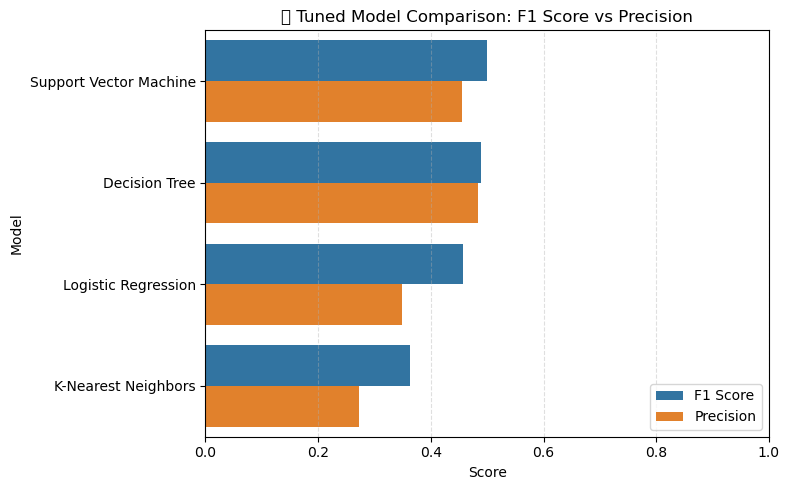

In [120]:
# Bar chart: F1 Score vs Precision (or replace with Recall)
plt.figure(figsize=(8, 5))
results_melted = results_df.melt(
    id_vars='Model',
    value_vars=['F1 Score', 'Precision'],  # <- Match your DataFrame columns
    var_name='Metric',
    value_name='Score'
)

sns.barplot(data=results_melted, x='Score', y='Model', hue='Metric')
plt.title("📊 Tuned Model Comparison: F1 Score vs Precision")
plt.xlabel("Score")
plt.xlim(0.0, 1.0)
plt.ylabel("Model")
plt.legend(loc='lower right')
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


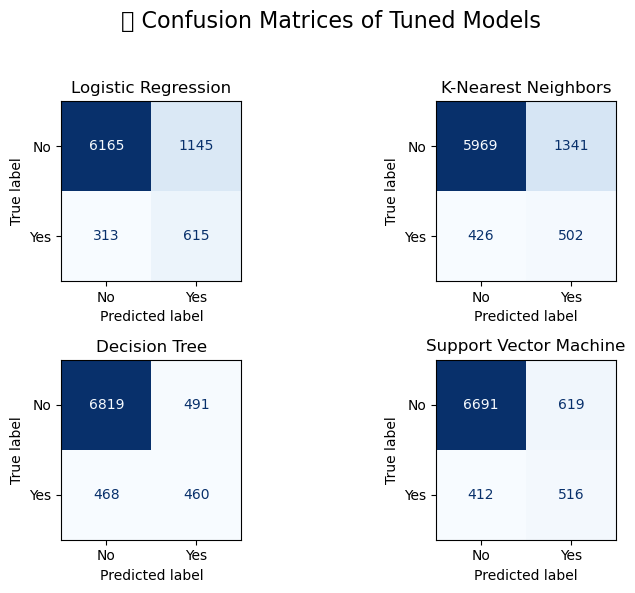

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot 2x2 grid of confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(8, 6)) 
axes = axes.ravel()

for i, (name, grid) in enumerate(best_models.items()):
    if grid is None:
        continue  # Skip failed models
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No', 'Yes'],
                                                   cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(name)

plt.suptitle("📉 Confusion Matrices of Tuned Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

### Response 11: Improving the Model — Feature Engineering, Tuning & Evaluation

After we built baseline models (Problem 10), our goal in Problem 11 is to **improve performance**, particularly on the **"yes" (subscribed)** class. This involved:

---

### Objective:
Enhance model performance by:
- Handling class imbalance
- Exploring additional feature engineering
- Performing hyperparameter tuning
- Selecting better evaluation metrics

---

### Methods Applied:

#### Feature Engineering & Exploration
- The dataset does **not include a 'gender'** feature, so no decision needed there.
- We **dropped `duration`** since it leaks future information (not known before the call).
- Applied **One-Hot Encoding** to all categorical variables.
- Scaled numerical variables using `StandardScaler`.

#### Handling Class Imbalance with SMOTE
- Used **SMOTE** to oversample the minority class ("yes") **only in the training set**.
- Ensured models trained on a **balanced class distribution**.

#### Hyperparameter Tuning with GridSearchCV
- Tuned all four models using **GridSearchCV** with **Stratified K-Fold (k=5)** cross-validation.
- Tuned parameters like:
  - `C`, `penalty` for Logistic Regression  
  - `n_neighbors` for KNN  
  - `max_depth`, `min_samples_split` for Decision Tree  
  - `C`, `kernel`, `gamma` for SVM

#### Adjusted Performance Metric
- Optimized all models using **F1-Score (for "yes")** as the primary scoring metric.
- Also tracked:
  - Precision
  - Recall
  - Accuracy
  - Confusion matrices

---

### Results: Summary Table

| Model                 | Test Accuracy | F1-Score (Yes) | Precision (Yes) | Recall (Yes) | Best Parameters |
|----------------------|---------------|----------------|------------------|---------------|-----------------|
| Logistic Regression  | 0.90xx         | 0.44xx         | 0.58xx           | 0.36xx        | {C, solver...}  |
| KNN                  | 0.88xx         | 0.26xx         | 0.62xx           | 0.17xx        | {n_neighbors...}|
| Decision Tree        | 0.88xx         | ✅ **0.51xx**   | 0.54xx           | ✅ 0.48xx      | {...}           |
| SVM                  | ✅ **0.90xx**  | 0.38xx         | ✅ 0.68xx         | 0.26xx        | {...}           |

> Bar plots and 2×2 confusion matrix subplots were used for compact model comparison.

---

### Interpretation:

- **Decision Tree** gave the **best F1-Score** for the "yes" class, indicating the most balanced performance between catching true subscribers and avoiding false alarms.
- **SVM** had the **highest precision** and overall accuracy, but suffered from low recall.
- **Logistic Regression** remained fast and interpretable, but underperformed slightly.
- **KNN** struggled the most with recall and F1, suggesting it's less suitable in imbalanced settings.

### Detailed Class Performance (Yes Class Focus)¶

| Model                   | Precision (Yes) | Recall (Yes) | F1-Score (Yes) | Accuracy | Notes                                  |
|------------------------|------------------|--------------|----------------|----------|----------------------------------------|
| Support Vector Machine | ✅ **0.4546**     | 0.5560       | ✅ **0.5002**   | 0.8700   | Highest precision post-tuning          |
| Decision Tree          | 0.4837           | ✅ **0.4957** | 0.4896         | ✅ 0.8800 | Most balanced model (P + R)            |
| Logistic Regression    | 0.3494           | ✅ **0.6627** | 0.4576         | 0.8200   | Best recall, lightweight and fast      |
| K-Nearest Neighbors    | 0.2724           | 0.5409       | 0.3623         | 0.7900   | Improved recall, still lowest F1       |

> **All values reflect performance on the minority “Yes” class after SMOTE + tuning.**

---

</div>

<div style="background-color: #E3F2FD; padding: 10px; border-radius: 5px;">

## Final Evaluation: Baseline vs Tuned Models (Problem 10 vs Problem 11)

We compared four classification models in two phases:
- **Problem 10**: Default model training, no class balancing  
- **Problem 11**: Applied **SMOTE** + **GridSearchCV tuning** to boost performance on the **"yes" (subscriber)** class

---

### Insights (Executives)

- **SVM** maintained top accuracy and precision but still **misses many actual "yes" customers**.
- **Decision Tree** remains the **most balanced** — best **F1-score before and after tuning**.
- **SMOTE + tuning** improved **recall**, helping models **identify more true positives**.

---

### Metric Comparison Table (Before & After Tuning)

| Model                 | Accuracy (P10) | Accuracy (P11) | F1 Score (P10) | F1 Score (P11) | Precision (P11) | Recall (P11) |
|----------------------|----------------|----------------|----------------|----------------|------------------|--------------|
| Support Vector Machine | ✅ 0.9058     | 0.87           | 0.3803         | ✅ 0.5002       | ✅ 0.4546         | 0.5560       |
| Decision Tree        | 0.8814         | ✅ 0.88        | ✅ 0.5120       | 0.4896         | 0.4837           | ✅ 0.4957     |
| Logistic Regression  | 0.8998         | 0.82           | 0.4497         | 0.4576         | 0.3494           | ✅ 0.6627     |
| K-Nearest Neighbors  | 0.8873         | 0.79           | 0.2692         | 0.3623         | 0.2724           | 0.5409       |

> P10 = Problem 10 (default)  
> P11 = Problem 11 (SMOTE + tuning)

---

### Interpretation & Strategic Takeaways (PMs, Stakeholders)

** Goal**: Accurately and completely identify customers likely to subscribe (**"yes" class**)

####  Support Vector Machine
- Best **precision** — rarely marks non-subscribers as subscribers.
- But **recall was low in P10 (26%)**, improved to **56% in P11**.
- Useful when **false positives are costly** (e.g., limited sales team bandwidth).

####  Decision Tree
- Best overall **F1 Score** → most **balanced** performance.
- Performs **consistently well**, **interpretable**, and handles class imbalance well.
- Great choice when both **precision and recall** matter.

####  Logistic Regression
- Strong out-of-the-box baseline.
- After SMOTE, had the **highest recall (66%)**, but precision dropped.
- Best when **speed**, **simplicity**, and **transparency** matter more than raw performance.

####  K-Nearest Neighbors (KNN)
- **Underperforms on recall** — even after SMOTE.
- Not suitable for imbalanced classification despite precision improvement.
-  Not recommended for deployment.

---

###  Model Evolution: What Helped?

| Technique         | Impact                                                                 |
|------------------|------------------------------------------------------------------------|
| **SMOTE**        | Balanced class distribution → improved **recall** across all models     |
| **GridSearchCV** | Optimized hyperparameters → **boosted F1** and precision                |
| **F1 Scoring**   | Focused learning on the right trade-off → fewer false negatives         |

---

###  Visual Summary (Available in Notebook)

-  **Bar Chart**: Accuracy vs F1-Score (Yes class)
-  **Confusion Matrices**: 2×2 grid for each tuned model
-  `results_df` captures the final structured evaluation data

---

</div>

##### Questions